# SMI Data Reduction for Grazing-Incidence Energy Scans

### Setup
##### Package imports

In [1]:
import os
# os.environ["OMP_NUM_THREADS"] = "1" # Prevent numpy from using multiple threads when using emcee multiprocessing.
# These packages should all be installed if the procedure was followed
%matplotlib inline
import matplotlib, matplotlib.pyplot as plt, matplotlib.colors as mplc
matplotlib.interactive(True)
plt.ion()
from smi_analysis import SMI_beamline
import numpy as np, numpy.typing as npt
import pandas as pd
import fabio
import logging
import scipy.constants as const
import time
import corner
from typing import Literal, Callable
import emcee
import tqdm, tqdm.notebook # For progress bars
from scipy.optimize import curve_fit
import warnings
import datetime
import subprocess

# Setup options
fabio.TiffIO.logger.setLevel(logging.ERROR)
pd.set_option("display.width", 1000) #display large filenames
pd.set_option('max_colwidth', None)

ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_csr: cannot import name 'ocl_azim_csr' from 'pyFAI' (/nsls2/conda/envs/2024-3.0-py312-tiled/lib/python3.12/site-packages/pyFAI/__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_lut for: cannot import name 'ocl_azim_lut' from 'pyFAI' (/nsls2/conda/envs/2024-3.0-py312-tiled/lib/python3.12/site-packages/pyFAI/__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_sort for: cannot import name 'ocl_sort' from 'pyFAI' (/nsls2/conda/envs/2024-3.0-py312-tiled/lib/python3.12/site-packages/pyFAI/__init__.py)


In [2]:
# Define some useful functions
en2wav = lambda en: const.h * const.c / (const.e * en)
"""Function to convert energy (eV) to wavelength"""
en2wav(2.45e3)

5.060579527885725e-10

##### Experimental configuration

In [3]:
geometry: Literal['Transmission'] | Literal['Reflection'] = 'Reflection'
"""The measurement geometry"""
energy: float = 2.45e3
"""The energy (keV) at which the scan is performed"""
wavelength: float = en2wav(energy)
"""The wavelength corresponding to `energy`."""
beamstop_type: Literal["pindiode"] | Literal['rod'] = 'pindiode'
"""The beamstop type"""
incident_angle = 0
"""The default incident angle (varies) in degrees"""

#WAXS
detector_waxs: Literal['Pilatus900kw'] | Literal['Pilatus1m'] = 'Pilatus900kw'
"""Type of WAXS/SAXS detector"""
sdd_waxs: float | int = 280 # In mm
"""Sample to detector distance in millimeters"""
center_waxs: tuple[int|float, int|float] = (#97, 1255.9]
                                            # 215, 97
                                            218, 95) #218, 306  --> 306-211 = 95? Module is 211 for it's beginning frame.
"""Coordinates of the beam centre at 0 degrees, for the middle detector strip"""
bs_pos_waxs: list[tuple[int, int]] = [(0, 0),
                                      (0, 0), 
                                      (0, 0)
                                     ]
"""The position of the center of the beam stop for each detector angle; [0,0] implies not measured. 
This coordinate is relative to the stitch of the 3 detector strips."""
detector_angles: list[int | float] | npt.NDArray[np.float64 | np.int_] = np.deg2rad(np.array([17.7]) - 0.06) #0.06 is the correction for the WAXS 0 deg detector position
"""The angles of the detector in radians. 
May need to include corrections (-0.06 degs at 0, -0.36 at 20 deg) for position offsets."""


display(pd.DataFrame([
    ("Geometry", geometry),
    ("Energy (keV)", energy),
    ("Wavelength (nm)", wavelength * 1e9),
    ("Sample to Detector Distance (mm)", sdd_waxs),
    ("Beamstop Type", beamstop_type),
    ("Incident Angle (deg)", incident_angle),
    ("Detector Type", detector_waxs),
    ("Center Coords", center_waxs),
    ("Beamstop Coords", bs_pos_waxs),
    ("Detector Angles", detector_angles)
], columns=["Parameter", "Value"]))

#Test the configuration can be loaded!
SMI_waxs = SMI_beamline.SMI_geometry(geometry = geometry,
                                     wav = wavelength,
                                     sdd = sdd_waxs,
                                     alphai = incident_angle,
                                     detector = detector_waxs,
                                     center = center_waxs,
                                     bs_pos = bs_pos_waxs,
                                     bs_kind = beamstop_type,
                                     det_angles=detector_angles)

angles = [detector_angles[0] - np.deg2rad(7.47), detector_angles[0], detector_angles[0] + np.deg2rad(7.47)]
SMI_waxs.calculate_integrator_gi(angles)

,Parameter,Value
0,Geometry,Reflection
1,Energy (keV),2450.0
2,Wavelength (nm),0.506058
3,Sample to Detector Distance (mm),280
4,Beamstop Type,pindiode
5,Incident Angle (deg),0
6,Detector Type,Pilatus900kw
7,Center Coords,"(218, 95)"
8,Beamstop Coords,"[(0, 0), (0, 0), (0, 0)]"
9,Detector Angles,[0.3078760800517997]


### Flatfield Data
Data to normalise the detector pixels and remove background.

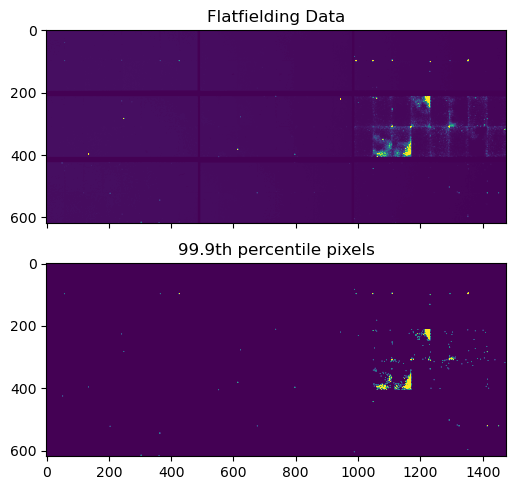

In [4]:
# Past beamline data for flat fielding (normalizing default pixel intensities)
# Note this is done at 2478eV, not all energies.

DRIVE = "/"

# # 2024 Cycle 2 Flatfielding
# CYCLE_FLAT = '2024_3'
# PROPOSAL_FLAT= '314483-Freychet-Flatfielding'
# FLAT_FILE = 'GF_flatfield_Sedge_2450uhighg1600_WZY11_wa30deg_2478eV_20s_id701601_000000_WAXS.tif'

# 2024 Cycle 3 Flatfielding
PROPOSAL_FLAT= '314483_Freychet_15'
FLAT_FILE = 'GF_flatfield_energy2450.00eV_uhighg1600_AEM_3s_2830.00eV_wa40.0_id891696_000000_WAXS.tif'

# Compile and load the flatfield path
FLAT_DIR_PATH = f'{DRIVE}/nsls2/data/smi/legacy/results/data/2025_1/{PROPOSAL_FLAT}/900KW/'
flatfield: npt.NDArray = np.rot90(fabio.open(os.path.join(FLAT_DIR_PATH, FLAT_FILE)).data, 1)

fig,ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))
p = 99.9
percentile = np.percentile(flatfield, p) #99.9th percentile
ax[0].imshow(np.rot90(flatfield, 3), vmin=0, vmax=percentile, interpolation=None)
ax[0].set_title("Flatfielding Data")

erronous =  (flatfield > percentile) * 1.0
ax[1].imshow(np.rot90(erronous,3), vmin=0, vmax=np.max(erronous)/5, interpolation=None)
ax[1].set_title(f"{p}th percentile pixels")
fig.tight_layout()
# plt.close()

### Extra functions for SMI Beamline Masking

##### Detector Masking

In [5]:
def apply_detector_mask_to_array(
    mask: npt.NDArray = np.zeros((1475, 195), dtype=bool)
) -> npt.NDArray[np.bool_]:
    """Sets an array mask for bad pixels; should only be applied to the middle column array"""
    mask[1254:1256, 47] = True
#     mask[979:1050, 0:100] = True
    mask[967, 67] = True
#     mask[490:555, 100:] = True
    mask[1231:1233, 174] = True
    mask[1414: 1416, 179] = True
    mask[858:860, 5] = True
    mask[414, 6] = True
    mask[394, 138] = True
    mask[364:366, 41] = True
    mask[364:366, 96] = True
    mask[304:306, 96:98] =  True
    mask[988, 188:194] = True
    mask[:, 1] = True
    mask[473, 20] = True
    mask[98, 5] = True
    mask[141, 111] = True
#     mask[240:300, 0:50] = True
#     mask[300:425, 125:] = True
    mask[181:183, 97:99] = True
    mask[553:555, 99:100] = True
    # Mask out the final column for the middle row.
    mask[:1475//3] = True

    return mask

def apply_boundary_mask_to_array(
    mask: npt.NDArray = np.zeros((1475, 195), dtype=bool)
) -> npt.NDArray[np.bool_]:
    """Sets an array mask for the boundary pixels; should only be applied to the middle column array"""
    mask[0, :] = True
    mask[-1, :] = True
    mask[:, 0] = True
    mask[:, -1] = True
    return mask

def apply_detector_mask(geom: SMI_beamline.SMI_geometry) -> None:
    """Applies a pre-defined mask for the bad pixels in the SMI beamline"""
    for i, mask in enumerate(geom.masks):
        # Dead pixels in the 2nd detector strip.
        if i%3 == 1: # For multiple WAXS images, always masks the 2nd strip.
            apply_detector_mask_to_array(mask)
        # Add a mask on the boundary
        apply_boundary_mask_to_array(mask)
    return


##### Flatield Masking

In [6]:
FLATFIELD_PERCENTILE = 97.5
"""The percentile of the flatfield data to mask."""
# SAMPLE_PERCENTILE = 100.00
SAMPLE_PERCENTILE = 100.00
"""The percentile of the real data to mask."""

# For flatfielding, ignore/mask reigons between detector pixels.
FLATFIELD_SLICES = [slice(0, 195),  # Ign. flatfield above first frame
                    slice(211, 406),# Ign. flatfield outside middle  
                    slice(-195, None)] # Ign. flatfield below first frame
            
def flatfield_mask(flatfield: npt.NDArray = flatfield, 
                   percentile: float = FLATFIELD_PERCENTILE, 
                   min: float | int = 0) -> npt.NDArray[np.bool_]:
        """
        Returns a mask of flatfield data as a boolean numpy array.
        
        Masks pixels above the `percentile` (by default 99.9)
        and values less than `min` (by default 1).
        """
        # Calculate the 99.9th percentile of the total flatfield data
        p = np.percentile(flatfield, percentile) #99.9th percentile
        erronous =  flatfield > p
        # Also mask pixels well away from the standard deviation
        mean = np.mean(flatfield)
        std = np.std(flatfield)
        erronous |= flatfield > mean + 5*std
        
        # Also mask negative and zero pixels
        negative = flatfield < min
        # Return the overlap of the erronous and negative masks.
        return erronous | negative

def apply_flatfield(geom: SMI_beamline.SMI_geometry, 
                    flatfield: npt.NDArray, 
                    flat_percentile: float | int = FLATFIELD_PERCENTILE,
                    img_percentile: float | int = SAMPLE_PERCENTILE,
                    outliers: bool = False,
                    min : float | int = 1) -> None:
    """Applies a pre-defined flatfield mask and normalisation for the SMI beamline object"""
    flatmask = flatfield_mask(flatfield=flatfield, percentile=flat_percentile, min = min)
    for i, (mask, img) in enumerate(zip(geom.masks, geom.imgs)):
        fmask_i = flatmask[:, FLATFIELD_SLICES[i % 3]]
        # Apply the masking values
        masking_values = np.where(fmask_i == True)
        mask[masking_values] = True
        # Apply the normalisation 
        flat = flatfield[:, FLATFIELD_SLICES[i%3]] # Get flatfield panel
        flat[flat < 0] = 10000 # avoid negative values - note these are already masked
        # Multiply img by max of flatfield, then divide by flatfield to keep integer precision of img.
        temp = ((img * np.max(flatfield[:, FLATFIELD_SLICES[i%3]] * ~mask))
                / (flat * ~mask +1)) * ~mask # Avoid divide by zero, and zero mask values.
        # This line creates a runtime error due to casting... img is int32, flat is float64
        img[:] = temp.astype(np.int32)
    
        # Repeat mask for very large values erronously normalised
        if not img_percentile is None and img_percentile < 100:
            mask2 = flatfield_mask(flatfield=img, percentile=img_percentile, min = 0) # only consider positive values.
            masking_values2 = np.where(mask2 == True)
            mask[masking_values2] = True
        
        # Mask outliers in the data
        if outliers:
            img_mean = np.mean(img[~mask])
            img_std = np.std(img[~mask])
            mask[img > img_mean + 10*img_std] = True
    return


##### Show the stages of Flatfield masking

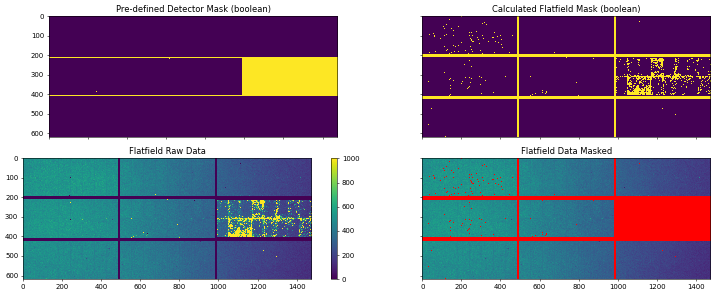

In [7]:
fig,ax = plt.subplots(2,2, figsize=(16,6), dpi=50, sharex=True, sharey=True)

# Detector image is (619, 1475) #619 is 195 * 3 + 2 * 17
# Show the detector masking
grid = np.zeros((195, 1475), dtype=bool)


det_mask = np.c_[apply_boundary_mask_to_array(grid.copy().T),
                 np.zeros((17, 1475), dtype=bool).T,
                 apply_detector_mask_to_array(apply_boundary_mask_to_array(grid.copy().T)), # 195 pixels
                 np.zeros((17, 1475), dtype=bool).T,
                apply_boundary_mask_to_array(grid.copy().T)]
    

det_im = ax[0][0].imshow(np.rot90(det_mask,3), interpolation='nearest') # required to prevent interpolation
ax[0][0].set_title("Pre-defined Detector Mask (boolean)")

# Show the flatfield masking
ff_masked = flatfield_mask(flatfield)
ff_masked_im = ax[0][1].imshow(np.rot90(ff_masked,3), interpolation='nearest') # required to prevent interpolation
ax[0][1].set_title("Calculated Flatfield Mask (boolean)")

# Show the flatfield image
ff_im = ax[1][0].imshow(np.rot90(flatfield,3), vmin = 0, vmax = np.mean(flatfield[~ff_masked]) + 5*np.std(flatfield[~ff_masked]), interpolation='nearest')
plt.colorbar(ff_im)
ax[1][0].set_title("Flatfield Raw Data")

# Show the masks on the flatfield image
joined_mask = ff_masked | det_mask
cmap = mplc.LinearSegmentedColormap.from_list("Mask", [(256,0,0,0),(256,0,0,256)], N=2)
ff_im_masked = ax[1][1].imshow(np.rot90(flatfield,3), interpolation='nearest',
                               vmin = 0, vmax = np.mean(flatfield[~ff_masked]) + 5*np.std(flatfield[~ff_masked]))
ax[1][1].imshow(np.rot90(joined_mask,3), cmap=cmap, interpolation='nearest')
ax[1][1].set_title("Flatfield Data Masked")

fig.tight_layout()
# plt.close()

### Energy Dependence Flux Calibration for MEX2 Beamline

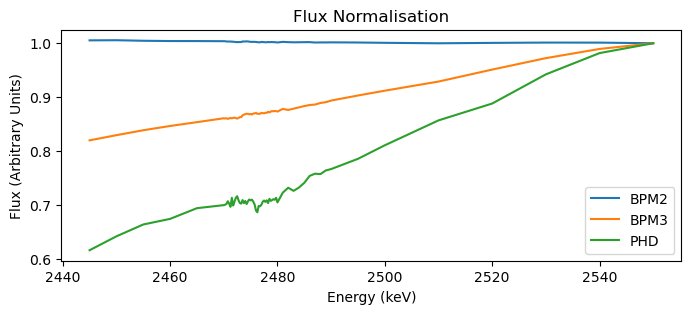

In [8]:
## Flux data from recording photodiode and BPMs
# 2024 Cycle 3 Flux
PROPOSAL_FLUX = '316022_McNeill_02'

# Compile and load the flux paths
FLUX_DIR_PATH = f'{DRIVE}nsls2/data/smi/legacy/results/data/2025_1/{PROPOSAL_FLUX}/1M/'
FLUX_FILES = [file for file in os.listdir(FLUX_DIR_PATH) if file.endswith('.tif') and "Sedge" in file and "eV" in file]

# Parse the flux data from the filenames
flux_energies = []
flux_norm_bpm2 = []
"""A collection of flux normalisation values for each flux file, also known as i0."""
flux_norm_bpm3 = []
"""A collection of flux normalisation values for each flux file, also known as i0."""
flux_norm_phd = []
"""A collection of flux normalisation values for each flux file, also known as i0."""
for file in FLUX_FILES:
    # Example Format:
    # CM_direct_beam_Sedge_2474.75eV_bpm2_124.304_bpm3_4.511_pd_20611.340_id806560_000000_SAXS.tif'
    en_idx = file.find('eV')
    en = float(file[en_idx-7:en_idx])
    bpm2_idx = file.find('bpm2_')
    bpm3_idx = file.find('bpm3_')
    phd_idx = file.find('pd_')
    bpm2 = float(file[bpm2_idx+5:bpm3_idx-1])
    bpm3 = float(file[bpm3_idx+5:phd_idx-1])
    phd = float(file[phd_idx+3:file.find('_id')])
    flux_energies.append(en)
    flux_norm_bpm2.append(bpm2)
    flux_norm_bpm3.append(bpm3)
    flux_norm_phd.append(phd)
    
# Sort the flux data by energy
idx = np.argsort(flux_energies)
flux_energies = np.array(flux_energies)[idx].tolist()
flux_norm_bpm2 = np.array(flux_norm_bpm2)[idx]
flux_norm_bpm3 = np.array(flux_norm_bpm3)[idx]
flux_norm_phd = np.array(flux_norm_phd)[idx]

# Normalise
flux_norm_bpm2 /= flux_norm_bpm2[-1]
flux_norm_bpm3 /= flux_norm_bpm3[-1]
flux_norm_phd /= flux_norm_phd[-1]

fig,ax = plt.subplots(1,1, figsize=(8, 3), sharex=True)
ax.plot(flux_energies, flux_norm_bpm2, label="BPM2")
ax.plot(flux_energies, flux_norm_bpm3, label="BPM3")
ax.plot(flux_energies, flux_norm_phd, label="PHD")
ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Flux (Arbitrary Units)")
ax.set_title("Flux Normalisation")
ax.legend()

/tmp/ipykernel_1928566/2068158174.py:86: RuntimeWarning: divide by zero encountered in divide
  pixel_summations /= pixel_summations[-1]
/tmp/ipykernel_1928566/2068158174.py:86: RuntimeWarning: invalid value encountered in divide
  pixel_summations /= pixel_summations[-1]


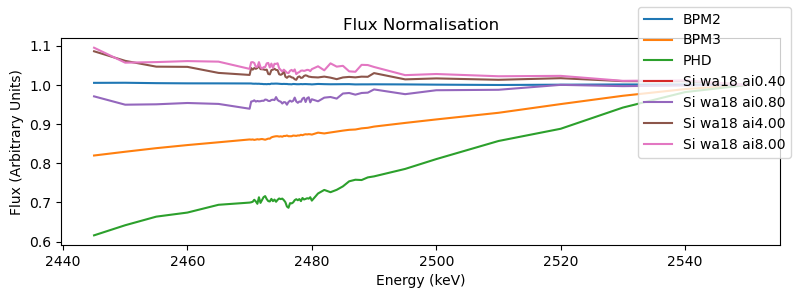

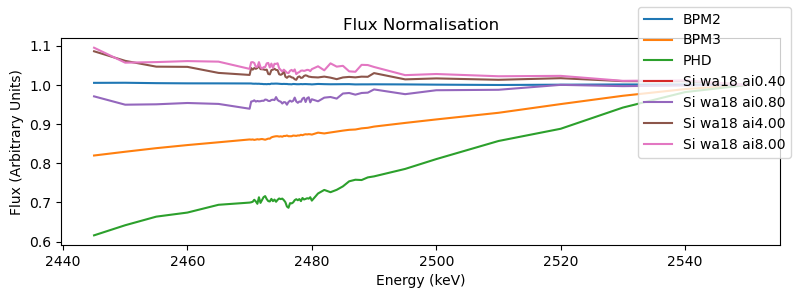

In [9]:
fig,ax = plt.subplots(1,1, figsize=(8, 3), sharex=True)
ax.plot(flux_energies, flux_norm_bpm2, label="BPM2")
ax.plot(flux_energies, flux_norm_bpm3, label="BPM3")
ax.plot(flux_energies, flux_norm_phd, label="PHD")
ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Flux (Arbitrary Units)")
ax.set_title("Flux Normalisation")

FLUX_OPTIONS: dict[str, dict[str, npt.NDArray]] = {}
FLUX_NORM: dict[str, npt.NDArray] = {}

for ai in ["ai0.40", "ai0.80", "ai4.00", "ai8.00"]:
    ## Additional flux data from silicon reference samples
    # Define the silicon reference data
    WAXS_ANGLE_STRINGS = ['wa18']
    FLUX_SI_CYCLE: str = '2025_1' #YYYY_[1-3]
    FLUX_SI_PROPOSAL_ID = '316022_McNeill_03' #PPPPPP_[Name]_[#]
    FLUX_SI_DIR = f'{DRIVE}nsls2/data/smi/legacy/results/data/2025_1/{FLUX_SI_PROPOSAL_ID}/900KW/'

    # Load the flux filenames
    FLUX_SI_FILES = [file for file in os.listdir(FLUX_SI_DIR) 
                    if file.endswith('.tif') 
                    and "_Si_" in file 
                    and "wide" not in file
                    and "calibrationai" not in file
                    and "clean" in file
                    and ai in file]
    
    if len(FLUX_SI_FILES) == 0:
         print(f"No files found for {ai}")
         #Skip
         continue
    
    flux_energies2 = []
    for j, file in enumerate(FLUX_SI_FILES):
        en_idx = file.find('eV')
        en = file[en_idx-7:en_idx]
        flux_energies2.append(float(en))
        # Sort the flux energies
        flux_energies2 = sorted(flux_energies2)
    
    FLUX_SI_DATASETS: list[list[str]] = [[""] * len(WAXS_ANGLE_STRINGS) for _ in flux_energies2]
    """For each energy, a list of raw data filenames for the silicon reference."""
    for j, file in enumerate(FLUX_SI_FILES):
        en_idx = file.find('eV')
        en = file[en_idx-7:en_idx]
        energies_idx = flux_energies2.index(float(en))
        waxs_angle_idx = [k for k, angle in enumerate(WAXS_ANGLE_STRINGS) if angle in file][0]
        FLUX_SI_DATASETS[energies_idx][waxs_angle_idx] = file

    pixel_summations: npt.NDArray[float] = np.zeros((len(flux_energies2), len(WAXS_ANGLE_STRINGS)))
    """The pixel summations for each sample, energy, and WAXS angle."""
    for j, en in enumerate(flux_energies2):
        for k, angle in enumerate(WAXS_ANGLE_STRINGS):
            if FLUX_SI_DATASETS[j][k] != "":
                # Load the data
                img = fabio.open(os.path.join(FLUX_SI_DIR, FLUX_SI_DATASETS[j][k])).data
                # Mask the data
                new_mask = np.zeros_like(img, dtype=bool).T
                apply_boundary_mask_to_array(new_mask)
                apply_detector_mask_to_array(new_mask)
                new_mask = new_mask.T
                img_mask = flatfield_mask(img, FLATFIELD_PERCENTILE, 0)

                # Perform a summation excluding masked pixels:
                img[img_mask | new_mask] = 0

                #619, 1475 only use middle module
                # Columns
                img[0:619//3] = 0
                # img[619//3 : 2*619//3] = 0
                img[2*619//3:] = 0
                # Rows
                img[:, 0:1475//3] = 0
                # img[:, 1475//3 : 2*1475//3] = 0
                img[:, 2*1475//3:] = 0

                # if j == 0 and k == 0:
                #     plt.figure()
                #     plt.imshow(img)
                #     display(img_mask.shape)

                pixel_summations[j][k] = np.sum(img)
    
    # Normalize the pixel summations
    pixel_summations /= pixel_summations[-1]
    si_ave = np.mean(pixel_summations, axis=1)

    # Plot results
    for k, angle in enumerate(WAXS_ANGLE_STRINGS):
        ax.plot(flux_energies2, pixel_summations[:, k], label=f'Si {angle} {ai}')

    # Select a flux channel for the analysis
    FLUX_CHANNEL = 'si_ave'
    match FLUX_CHANNEL:
        case 'si18':
                FLUX_NORM[ai] = pixel_summations[:, 0]
        case 'si_ave':
                FLUX_NORM[ai] = si_ave
        case _:
                raise ValueError("Invalid flux channel selected.")
    
    FLUX_OPTIONS[ai] = {
        'si18': pixel_summations[:, 0],
        'si_ave': si_ave
    }

# manually use 0.8 instad of 0.4
FLUX_NORM["ai0.40"] = FLUX_NORM["ai0.80"]

fig.tight_layout()
fig.legends
fig.legend()
display(fig)

### Data Import

##### Locate the files on your computer and define the output directory

In [10]:
CYCLE: str = '2024_3' #YYYY_[1-3]
PROPOSAL_ID = '316022_McNeill_04' #PPPPPP_[Name]_[#]
## ----------- Path to the raw data -----------

# RAW_PATH = f'D:/Datasets/2024-09 SMI/{CYCLE}/{PROPOSAL_ID}/900KW/'
RAW_DIR = f'{DRIVE}/nsls2/data/smi/legacy/results/data/2025_1/{PROPOSAL_ID}/900KW/'
display(pd.DataFrame(os.listdir(RAW_DIR), columns=["Filename"])) #use tail or head to display a subset

## ----------- Create/select the results directory -----------
RESULT_DIR = f'{DRIVE}/nsls2/data/smi/legacy/results/analysis/2025_1/{PROPOSAL_ID}/angle_scan_results/'
created = False
for i in range(len(RESULT_DIR.split("/"))):
    if not os.path.isdir("/".join(RESULT_DIR.split("/")[:i+1])) and not (i==0 and RESULT_DIR[0]=="/"):
        os.mkdir("/".join(RESULT_DIR.split("/")[:i+1]))
        created = True
if not created:
    print("Results path exists!")

,Filename
0,CM_A2_06p_2477.50eV_ai0.40_wa21_bpm155.312_id897136_000000_WAXS.tif
1,CM_A2_01p_2471.00eV_ai0.80_wa21_bpm155.752_id896319_000000_WAXS.tif
2,CM_wideincidentanglescan_A4_13p_2450.00eV_ai0.571_wa18_bpm155.974_id897866_000000_WAXS.tif
3,CM_A4_06p_2473.00eV_ai8.00_wa18_bpm155.556_id897734_000000_WAXS.tif
4,CM_wideincidentanglescan_A2_04p_2450.00eV_ai0.613_wa21_bpm156.013_id896599_000000_WAXS.tif
...,...
3855,CM_A4_06p_2476.75eV_ai0.40_wa18_bpm155.279_id897560_000000_WAXS.tif
3856,CM_A4_06p_2481.00eV_ai4.00_wa18_bpm155.456_id897700_000000_WAXS.tif
3857,CM_wideincidentanglescan_A4_01p_2450.00eV_ai0.514_wa18_bpm156.045_id899982_000000_WAXS.tif
3858,CM_A5_06p_2484.00eV_ai8.00_wa21_bpm155.461_id898620_000000_WAXS.tif


Results path exists!


##### Organise files into sample names and data for each detector angle

In [11]:
filename_flags: list[str] = ['wide', "A4"]
"""The strings you want included in the files processed."""
exclude_flags: list[str] = []
"""The strings you want excluded in the files processed."""

# Find all samples and energies
samples: list[str] = []
"""String names of the unique samples matching patterns in `filename_flags`"""
sample_energies: list[list[float]] = []
"""Unique energies found in the filenames for each sample"""
sample_energy_angles: list[list[list[float]]] = []
"""Unique angles found in the filenames for each sample and energy"""

for file in sorted(os.listdir(RAW_DIR)):
     # Define the flags for the files you want to process, by filtering the filename.
     if all([flag in file for flag in filename_flags] 
            + [flag not in file for flag in exclude_flags]):
        # Find the sample name:
        idx1 = file.find("scan_")
        idx2 = file.find("eV_")
        sample_substring = file[idx1+5:idx2-8]
        
        # If sample substring not in list of samples, add it!
        if sample_substring not in samples:
            sample_idx = len(samples)
            samples.append(sample_substring)
            # Add new lists for the angles and energies
            sample_energies.append([])
            sample_energy_angles.append([])
        else:
            sample_idx = samples.index(sample_substring)
        
        # Find the beam energy:
        en = float(file[idx2-7:idx2])
        if en not in sample_energies[sample_idx]:
            en_idx = len(sample_energies[sample_idx])
            sample_energies[sample_idx].append(en)
            # Add new list for the energies
            sample_energy_angles[sample_idx].append([])
        else:
            en_idx = sample_energies[sample_idx].index(en)
        
        # Find the angle of incidence:
        idx = file.find('_ai')
        ai = float(file[idx+3:idx+7])
        if ai not in sample_energy_angles[sample_idx][en_idx]:
            sample_energy_angles[sample_idx][en_idx].append(ai)
    
# Sort the energies and angles
for i in range(len(samples)): 
    for j in range(len(sample_energies[i])):
        # Sort the energies
        sample_energy_angles[i][j] = sorted(sample_energy_angles[i][j])
    # Sort the angles
    args = np.argsort(sample_energies[i])
    sample_energies[i] = np.array(sample_energies[i])[args].tolist()
    sample_energy_angles[i] = np.array(sample_energy_angles[i])[args].tolist()

# Specify the WAXS angles strings to look for, in each sample
WAXS_ANGLE_STRINGS : list[str] = ["wa18"]

# Find all TIF image measurements
datasets: list[list[list[list[str | None]]]] = [[[
                                                [None] * len(WAXS_ANGLE_STRINGS)
                                                for k, _ in enumerate(sample_energy_angles[i][j])]
                                            for j, _ in enumerate(sample_energies[i])]
                                        for i, _ in enumerate(samples)]
"""For each sample, for each energy, for each angle, a list of raw data filenames."""
for i, sample in enumerate(samples):
    for j, file in enumerate(sorted(os.listdir(RAW_DIR))):
        if all([flag in file for flag in filename_flags + [sample, '.tif']] 
                + [flag not in file for flag in exclude_flags]):
            # Check which waxs angle the file is
            en_idx = file.find('eV_')
            en = file[en_idx-7:en_idx]
            ai_idx = file.find('_ai')
            ai = file[ai_idx+3:ai_idx+7]
            sample_idx = file.find("scan_")
            # Double check the sample name matches the filename
            sample_substring = file[sample_idx+5:en_idx-8]
            if sample_substring != sample:
                continue
            # Find the index of the energy and angle
            energies_idx = sample_energies[i].index(float(en))
            angles_idx = sample_energy_angles[i][energies_idx].index(float(ai))
            waxs_angle_idx = [k for k, angle in enumerate(WAXS_ANGLE_STRINGS) if angle in file][0]
            datasets[i][energies_idx][angles_idx][waxs_angle_idx] = file

# Display the number of files for each sample:
display(
      pd.DataFrame([
            (sample, np.sum(
                [len(sample_energy_angles[i][j]) * len(WAXS_ANGLE_STRINGS)
                for j in range(len(sample_energies[i]))]
            ))
            for i, sample in enumerate(samples)
      ], columns=["Sample Name", "Number of Files"])
)

,Sample Name,Number of Files
0,A4_01p,25
1,A4_06p,82
2,A4_13p,82


##### Organise the unique energies, and interpolate any missing values for normalisaiton

In [12]:
global_energies = np.unique([en for en in sample_energies])
if np.all(global_energies != flux_energies):
    print("The flux energies do not match the global energies.")
    # print("Generating interpolated values")
    # for i, ai in enumerate(global_energies):
    #     if ai not in flux_energies:
    #         idx = np.searchsorted(flux_energies, en)
    #         flux_energies.insert(idx, en)
    #         flux_norm_bpm2 = np.r_[flux_norm_bpm2[:idx], np.interp(en, flux_energies, flux_norm_bpm2), flux_norm_bpm2[idx:]]
    #         flux_norm_bpm3 = np.r_[flux_norm_bpm3[:idx], np.interp(en, flux_energies, flux_norm_bpm3), flux_norm_bpm3[idx:]]
    #         flux_norm_phd = np.r_[flux_norm_phd[:idx], np.interp(en, flux_energies, flux_norm_phd), flux_norm_phd[idx:]]
    #         si0 = np.r_[pixel_summations[:, 0][:idx], np.interp(en, flux_energies, pixel_summations[:, 0]), pixel_summations[:, 0][idx:]]
    #         si20 = np.r_[pixel_summations[:, 1][:idx], np.interp(en, flux_energies, pixel_summations[:, 1]), pixel_summations[:, 1][idx:]]
    #         si_ave = np.r_[si_ave[:idx], np.interp(en, flux_energies, si_ave), si_ave[idx:]]
            
    #         # Re-assign new objects
    #         FLUX_OPTIONS = {
    #             'bpm2': flux_norm_bpm2,
    #             'bpm3': flux_norm_bpm3,
    #             'phd': flux_norm_phd,
    #             'si0': si0,
    #             'si20': si20,
    #             'si_ave': si_ave
    #         }

# Reduction
### Run the first sample to check everything is working and define the Q fit ranges

##### First check sample image exists and looks reasonable!

In [13]:
test_files: list[int] = [
    # 0, 20, 40, -2
    0, -2
    ]
"""The index of each sample's test file"""

"The index of each sample's test file"

A4_01p | CM_wideincidentanglescan__2450.00eV_ai0.200_wa18_bpm156.273_id899951_000000_WAXS.tif


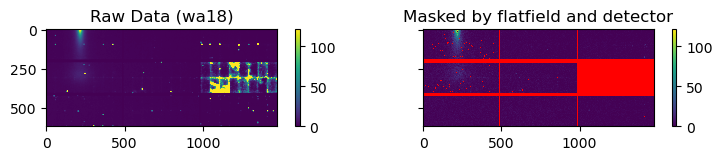

A4_01p | CM_wideincidentanglescan__2450.00eV_ai0.568_wa18_bpm156.082_id900000_000000_WAXS.tif


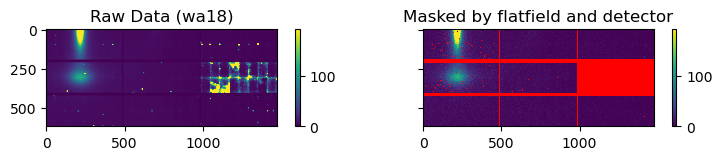

------------------------------
A4_06p | CM_wideincidentanglescan__2450.00eV_ai0.200_wa18_bpm155.949_id897389_000000_WAXS.tif


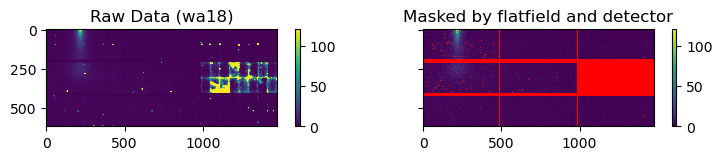

A4_06p | CM_wideincidentanglescan__2450.00eV_ai3.800_wa18_bpm155.910_id897526_000000_WAXS.tif


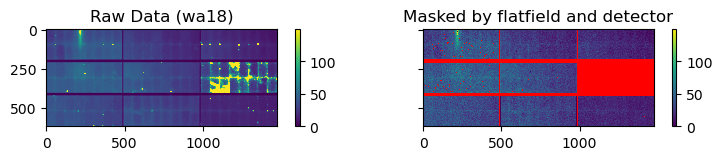

------------------------------
A4_13p | CM_wideincidentanglescan__2450.00eV_ai0.200_wa18_bpm156.026_id897816_000000_WAXS.tif


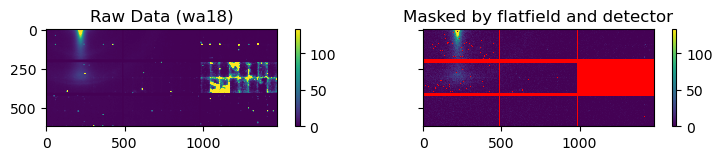

A4_13p | CM_wideincidentanglescan__2450.00eV_ai3.800_wa18_bpm155.986_id897953_000000_WAXS.tif


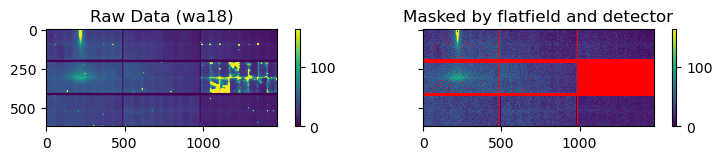

------------------------------


In [14]:
for i, sample in enumerate(samples):
    for j, en in enumerate(sample_energies[i]):
        for test_file in test_files:
            print(sample, "|", datasets[i][j][test_file][0].replace(sample, ""))
            fig,ax = plt.subplots(len(WAXS_ANGLE_STRINGS),2, figsize=(8,len(WAXS_ANGLE_STRINGS)*1.5), sharex=True, sharey=True)
            if len(WAXS_ANGLE_STRINGS) == 1:
                ax = [ax]
            for k, angle in enumerate(WAXS_ANGLE_STRINGS):
                fname = datasets[i][j][test_file][k]
                # fig.suptitle(sample)
                # Use 
                img=fabio.open(os.path.join(RAW_DIR, fname)).data
                mappable = ax[k][0].imshow(img, vmin=0, vmax=np.percentile(img,99))
                ax[k][0].set_title(f"Raw Data ({angle})")
                plt.colorbar(mappable)
                
                # Show the masks on the flatfield image
                cmap = mplc.LinearSegmentedColormap.from_list("Mask", [(256,0,0,0),(256,0,0,256)], N=2)
                ff_im_masked = ax[k][1].imshow(img, interpolation='nearest',
                                        vmin = 0, vmax = np.percentile(img, 99))
                ax[k][1].imshow(np.rot90(joined_mask,3), cmap=cmap, interpolation='nearest')
                ax[k][1].set_title("Masked by flatfield and detector")
                plt.colorbar(ff_im_masked)
            
            fig.tight_layout()
            plt.show()
        print("------------------------------")

##### Generate an image of the corrected missing wedge + updated mask

In [ ]:
for i, sample in enumerate(samples):
    # At each sample, reset the SMI_waxs object
    if SMI_waxs is not None and len(SMI_waxs.ai) != 0:
        # for ai in SMI_waxs.ai:
        #     ai.reset()
        SMI_waxs.ai = []
    for j, en in enumerate(sample_energies[i]):
        for test_file in test_files:
            # Setup a figure and open the file
            fig,ax = plt.subplots(1,3, figsize=(12,2.5), sharex=True, sharey=True)
            fnames = datasets[i][j][test_file]
            fname = fnames[0]
            
            # Collect the metadata
            en_idx = fname.find('eV_')
            en2 = float(fname[en_idx-7:en_idx])
            ai_idx = fname.find("_ai")
            ai = float(fname[ai_idx+3:ai_idx+7])
            assert(en == en2)
            
            display(pd.DataFrame([
                    (fname, en, ai)
                    ], columns=["Filename", "Energy (eV)", "Incident Angle (deg)"]))
            
            # Update the geometry/'
            tinit = datetime.datetime.now()
            SMI_waxs.alphai = ai
            tfin = datetime.datetime.now()
            print(f"Time to update geometry: {tfin-tinit}")
            
            tinit = datetime.datetime.now()
            SMI_waxs.wav = en2wav(en)
            tfin = datetime.datetime.now()
            print(f"Time to update wavelength: {tfin-tinit}")
            
            # Reset the masks
            for mask in SMI_waxs.masks:
                mask[:,:] = False
            
            # Plot the unmodified data
            SMI_waxs.open_data(RAW_DIR, fnames)
            
            SMI_waxs.stitching_data(interp_factor=2, flag_scale=False, timing=True if i==0 and j==0 else False, perpendicular=True)
            # mp = ax[0].imshow(SMI_waxs.img_st,
            #         extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
            mp = ax[0].imshow(SMI_waxs.img_st,
                    extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
                    # vmin=0,
                    vmax=np.percentile(SMI_waxs.img_st, 99)
            )
            plt.colorbar(mp)
            ax[0].set_title("Stitched Data (Raw)")
            
            # Plot the flatfield / masked normalized data
            SMI_waxs.open_data(RAW_DIR, fnames)
            apply_detector_mask(SMI_waxs)
            apply_flatfield(SMI_waxs, flatfield, flat_percentile=FLATFIELD_PERCENTILE, img_percentile=SAMPLE_PERCENTILE)
            apply_detector_mask(SMI_waxs)
            
            # Show the masks on the flatfield image
            a = ax[1]
            cmap = mplc.LinearSegmentedColormap.from_list("Mask", [(256,0,0,0),(256,0,0,256)], N=2)
            ff_im_masked = a.imshow(SMI_waxs.imgs[0], interpolation='nearest',
                                    vmin = 0, vmax = np.percentile(img, 99))
            a.imshow(SMI_waxs.masks[0], cmap=cmap, interpolation='nearest')
            a.set_title("Masked by flatfield and detector")
            plt.colorbar(ff_im_masked)
            
            
            SMI_waxs.stitching_data(interp_factor=1, flag_scale=True, perpendicular=True)
            # mp = ax[1].imshow(SMI_waxs.img_st,
                    # extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
            mp = ax[1].imshow(SMI_waxs.img_st,
                    extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
                    # vmin=np.percentile(SMI_waxs.img_st, 1.0), 
                    vmax=np.percentile(SMI_waxs.img_st, 99.0)
            )
            plt.colorbar(mp)
            ax[1].set_title("Stitched (Norm. + Custom Masked)")
            
            # Show the total mask over the image
            cmap = mplc.LinearSegmentedColormap.from_list("Mask", [(256,0,0,0),(256,0,0,256)], N=2)
            mp = ax[2].imshow(SMI_waxs.img_st,
                    extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
                    # vmin=np.percentile(SMI_waxs.img_st, 1.0), 
                    vmax=np.percentile(SMI_waxs.img_st, 99.0)
            )
            ax[2].imshow(SMI_waxs.mask_st,
                    extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1],],
                    cmap=cmap,
                    interpolation='nearest'
            )
            # plt.colorbar(mp)
            ax[2].set_title("Detector mask + custom mask")
            fig.show()
            plt.show()
            break
        break
    break

,Filename,Energy (eV),Incident Angle (deg)
0,CM_wideincidentanglescan_A4_01p_2450.00eV_ai0.200_wa18_bpm156.273_id899951_000000_WAXS.tif,2450.0,0.2


Time to update geometry: 0:00:00.000011
Time to update wavelength: 0:00:00.000010
Time to calculate the integrator: 0:00:06.388921
Time to calc perpendicular geometry: 0:00:01.718773


##### Generate a ROI to check the beam-centre 
###### Also check that the beamcentre is correct by symmetry (unless sample has anisotropic behavour)

In [29]:
# Define the radial angles
AZIMUTHAL_WIDTH = 10
"""The +- azimuthal width of the orthogonal range"""
AZIMUTHAL_INPLANE = 10
"""The azimuthal angle for the in-plane scattering"""
AZIMUTHAL_OUTOFPLANE = 80
"""The azimuthal angle for the out-of-plane averaging"""
RADIAL_WIDTH = 35
"""The +- azimuthal width for the radial averaging"""
AZIMUTHAL_RADIAL = 45
"""The azimuthal angle for the radial averaging"""

'The azimuthal angle for the radial averaging'

,Filename,Energy (eV),Incident Angle (deg)
0,CM_wideincidentanglescan_A1_01_2450.00eV_ai0.200_wa18_bpm156.159_id893472_000000_WAXS.tif,2450.0,0.2


KeyboardInterrupt: 

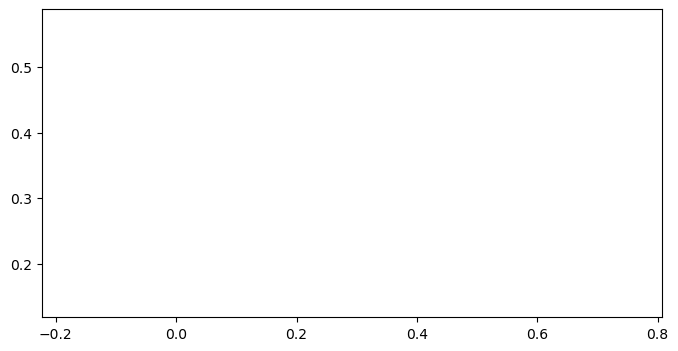

In [30]:
for i, sample in enumerate(samples):
    for j, en in enumerate(sample_energies[i]):
        for test_file in test_files:
            # Setup a figure and open the file
            fnames = datasets[i][j][test_file]
            if None in fnames:
                print(f"Skipping {sample} due to missing files.")
                continue
            fname = fnames[0]
            
            # Collect the metadata
            en_idx = fname.find('eV_')
            en2 = float(fname[en_idx-7:en_idx])
            ai_idx = fname.find("_ai")
            ai = float(fname[ai_idx+3:ai_idx+7])
            assert(en == en2)
            display(pd.DataFrame([
                    (fname, en, ai)
                    ], columns=["Filename", "Energy (eV)", "Incident Angle (deg)"]))
            
            # Update the geometry
            SMI_waxs.alphai = ai
            SMI_waxs.wav = en2wav(en)

            # Show the angles on a plot
            fig,ax = plt.subplots(1,1, figsize=(8,4), sharex=True, sharey=True)
            ax.set_ylim(SMI_waxs.qz[0], SMI_waxs.qz[-1])
            ax.set_xlim(SMI_waxs.qp[0], SMI_waxs.qp[-1])

            SMI_waxs.open_data(RAW_DIR, fnames)
            apply_detector_mask(SMI_waxs)
            apply_flatfield(SMI_waxs, flatfield)
            energies_idx = flux_energies.index(en) # for normalisation
            for img in SMI_waxs.imgs:
                # img[:] = (img[:] / FLUX_NORM[f"ai{ai:0.2f}"][energies_idx]).astype(np.int32)
                pass
            SMI_waxs.stitching_data(interp_factor=5, flag_scale=True, perpendicular=True)
            # mp = ax[1].imshow(SMI_waxs.img_st,
                    # extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
            mp = ax.imshow(SMI_waxs.img_st,
                    extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
                    vmin=np.percentile(SMI_waxs.img_st, 1.0), 
                    vmax=np.percentile(SMI_waxs.img_st, 99.0)
            )
            plt.colorbar(mp)

            # Plot the azimuthal and radial angles
            colors = ['r', 'orange', 'white'][::-1]
            for angle, width in zip([AZIMUTHAL_INPLANE, AZIMUTHAL_OUTOFPLANE, AZIMUTHAL_RADIAL], [AZIMUTHAL_WIDTH, AZIMUTHAL_WIDTH, RADIAL_WIDTH]):
                    # Generate a set of x points to plot lines of.
                    q_x = np.linspace(0, SMI_waxs.qp[-1], 100)
                    # Calculate the x and y gradients for the lines
                    m1 = np.tan(np.deg2rad(angle - width)) if angle - width != 90 else np.inf
                    m2 = np.tan(np.deg2rad(angle + width)) if angle + width != 90 else np.inf
                    # Calculate the x & y values for the lines
                    q_x1 = q_x if m1 != np.inf else np.zeros(100)
                    q_x2 = q_x if m2 != np.inf else np.zeros(100)
                    y1 = m1 * q_x if m1 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                    y2 = m2 * q_x if m2 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                    # Plot the lines
                    color = colors.pop()
                    ax.plot(q_x1, y1, color=color, linestyle='-', label=f"{angle} deg")
                    ax.plot(q_x2, y2, color=color, linestyle='-')
                    # If gradient is inf, calculate an alternative fill between
                    if m2 == np.inf:
                            ax.fill_betweenx(y1, q_x1, q_x2, color=color, alpha=0.1)
                    else:
                            ax.fill_between(q_x, y1, y2, color=color, alpha=0.1)
            ax.legend()
            plt.show()
            # ax.close()


##### Calculate the azimuthal/radial averages

In [31]:
NPOINTS_RADIAL_AVE: int = 2000 # Use a number the is consistent with the pixel density?

,Filename,Energy (eV),Incident Angle (deg)
0,CM_wideincidentanglescan_A1_01_2450.00eV_ai0.200_wa18_bpm156.159_id893472_000000_WAXS.tif,2450.0,0.2


Time to update geometry: 0:00:00.362099
Time to update wavelength: 0:00:00.000005
Time to open data: 0:00:00.004836
Time to apply masks: 0:00:00.012293
Time to normalise data: 0:00:00.000006
Time to stitch data: 0:00:05.801861
Time to radial average: 0:00:12.167505


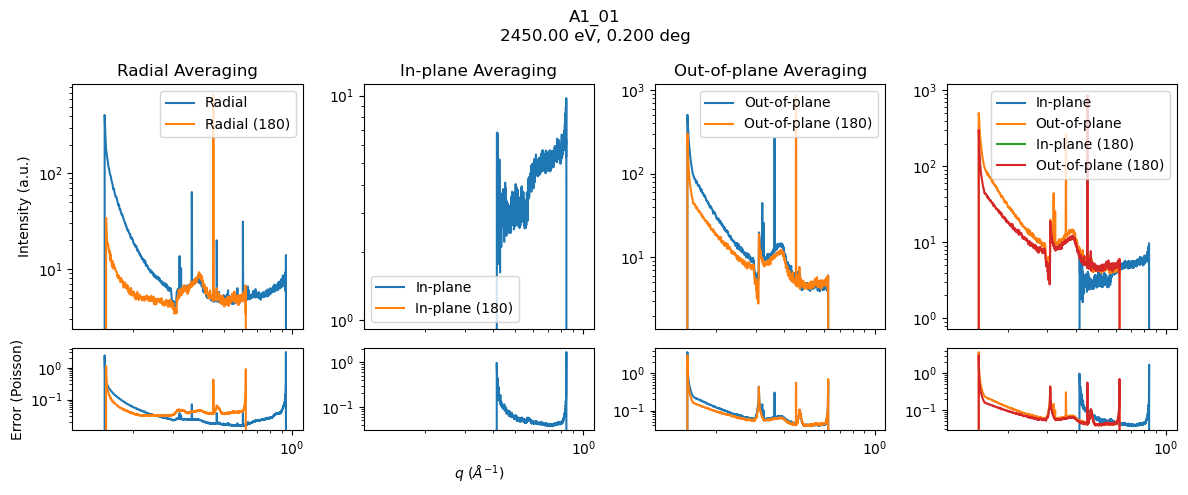

Time to plot: 0:00:01.068856


,Filename,Energy (eV),Incident Angle (deg)
0,CM_wideincidentanglescan_A1_01_2450.00eV_ai3.800_wa18_bpm156.221_id893609_000000_WAXS.tif,2450.0,0.2


Time to update geometry: 0:00:00.000007
Time to update wavelength: 0:00:00.000005
Time to open data: 0:00:00.007062
Time to apply masks: 0:00:00.012878
Time to normalise data: 0:00:00.000009
Time to stitch data: 0:00:05.590840
Time to radial average: 0:00:12.296703


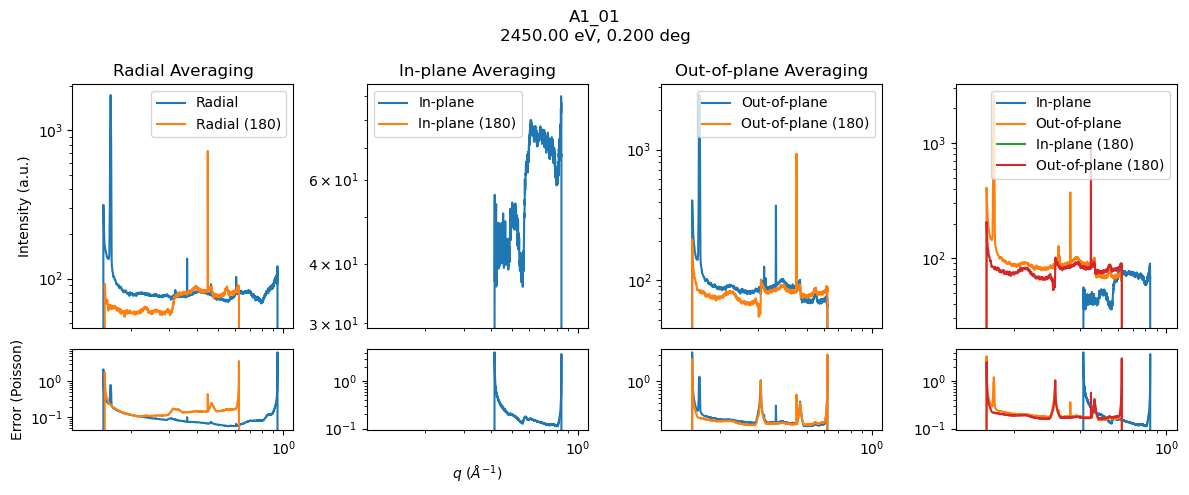

Time to plot: 0:00:00.825440


,Filename,Energy (eV),Incident Angle (deg)
0,CM_wideincidentanglescan_A1_02_2450.00eV_ai0.200_wa18_bpm156.105_id893899_000000_WAXS.tif,2450.0,0.2


Time to update geometry: 0:00:00.000003
Time to update wavelength: 0:00:00.000004
Time to open data: 0:00:00.004953
Time to apply masks: 0:00:00.010919
Time to normalise data: 0:00:00.000005
Time to stitch data: 0:00:05.561124
Time to radial average: 0:00:12.603207


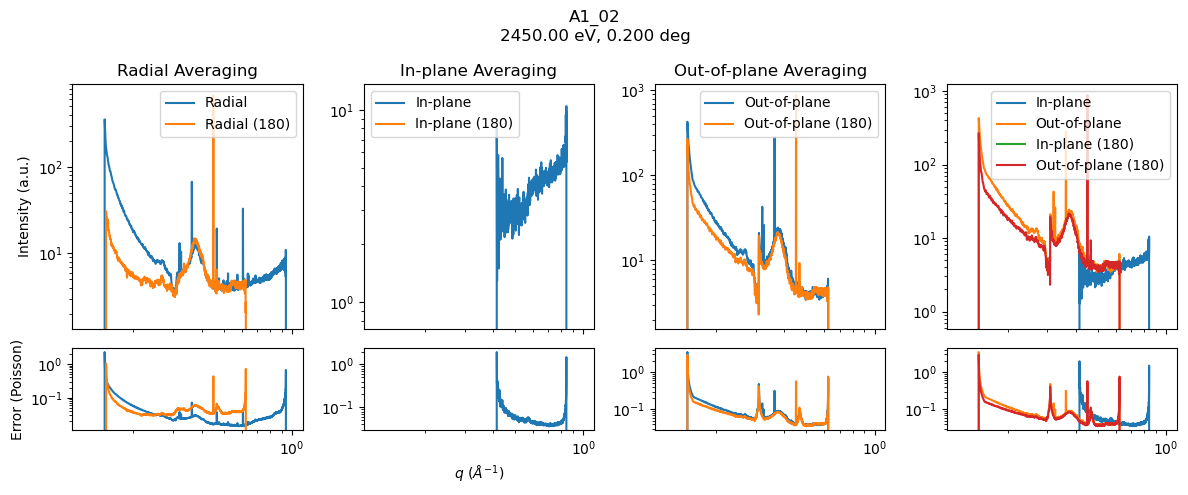

Time to plot: 0:00:01.130092


,Filename,Energy (eV),Incident Angle (deg)
0,CM_wideincidentanglescan_A1_02_2450.00eV_ai3.800_wa18_bpm156.184_id894036_000000_WAXS.tif,2450.0,0.2


Time to update geometry: 0:00:00.000006
Time to update wavelength: 0:00:00.000005
Time to open data: 0:00:00.004956
Time to apply masks: 0:00:00.011257
Time to normalise data: 0:00:00.000005
Time to stitch data: 0:00:05.489321
Time to radial average: 0:00:12.316302


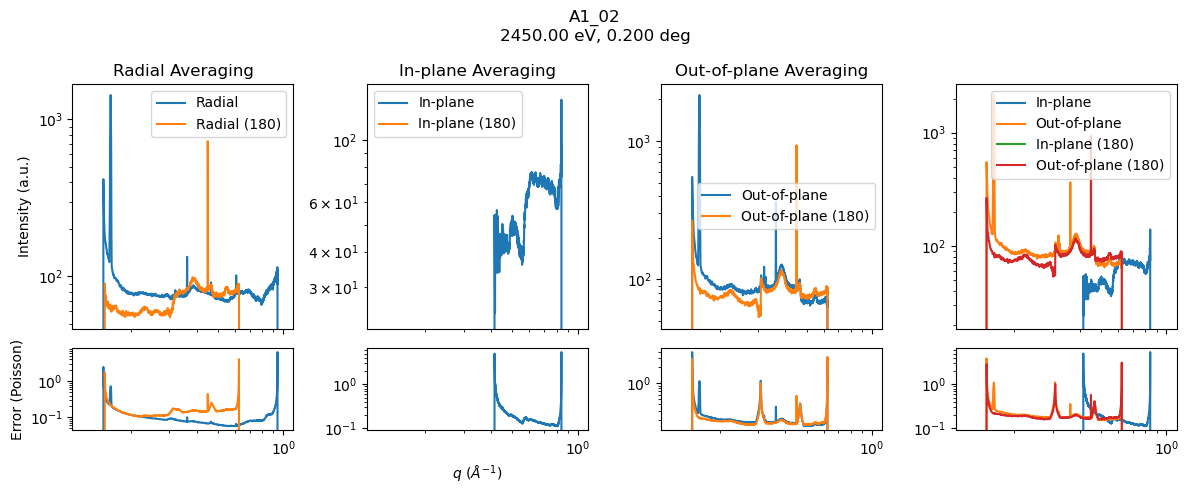

Time to plot: 0:00:01.127933


In [25]:
for i, sample in enumerate(samples):
    for j, en in enumerate(sample_energies[i]):
        for test_file in test_files:
            # Setup a figure and open the file
            fnames = datasets[i][j][test_file]
            fname = fnames[0]
            
            # Collect the metadata
            en_idx = fname.find('eV_')
            en2 = float(fname[en_idx-7:en_idx])
            ai_idx = fname.find("_ai")
            ai2 = float(fname[ai_idx+3:ai_idx+7])
            assert en==en2
            display(pd.DataFrame([
                    (fname, en, ai)
                    ], columns=["Filename", "Energy (eV)", "Incident Angle (deg)"]))
            
            # Update the geometry
            tinit = datetime.datetime.now()
            SMI_waxs.alphai = ai
            tfin = datetime.datetime.now()
            print(f"Time to update geometry: {tfin-tinit}")
            
            tinit = datetime.datetime.now()
            SMI_waxs.wav = en2wav(en)
            tfin = datetime.datetime.now()
            print(f"Time to update wavelength: {tfin-tinit}")

            # Open and stitch the data
            tinit = datetime.datetime.now()
            SMI_waxs.open_data(RAW_DIR, fnames)
            tfin = datetime.datetime.now()
            print(f"Time to open data: {tfin-tinit}")
            
            tinit = datetime.datetime.now()
            apply_detector_mask(SMI_waxs)
            apply_flatfield(SMI_waxs, flatfield)
            tfin = datetime.datetime.now()
            print(f"Time to apply masks: {tfin-tinit}")
            
            tinit = datetime.datetime.now()
            energies_idx = flux_energies.index(en) # for normalisation
            for img in SMI_waxs.imgs:
                # img[:] = (img[:] / FLUX_NORM[energies_idx]).astype(np.int32)
                pass
            tfin = datetime.datetime.now()
            print(f"Time to normalise data: {tfin-tinit}")
                
            tinit = datetime.datetime.now()
            SMI_waxs.stitching_data(interp_factor=2, flag_scale=False, perpendicular=True)
            tfin = datetime.datetime.now()
            print(f"Time to stitch data: {tfin-tinit}")

            # Generate radial averages
            fig,ax = plt.subplots(2,4, figsize=(12,5), sharex=True, height_ratios=[3,1])
            fig.suptitle(f"{sample}\n{en:0.2f} eV, {ai:0.3f} deg")
            ax[0][0].set_xscale("log")

            tinit = datetime.datetime.now()
            # In plane and out of plane
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                    azimuth_range=[90 - (AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH) , 90 - (AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                                    npt = NPOINTS_RADIAL_AVE)
            q0_IP, I0_IP, I0_IP_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                    azimuth_range=[90 - (AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH), 90 - (AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                                    npt = NPOINTS_RADIAL_AVE)
            q0_OOP, I0_OOP, I0_OOP_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

            # Repeat IP and OOP for the consistency checking
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                    azimuth_range=[-90+(AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH), -90+(AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                                    npt = NPOINTS_RADIAL_AVE)
            q0_IP2, I0_IP2, I0_IP2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                    azimuth_range=[-90+(AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH) , -90+(AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                                    npt = NPOINTS_RADIAL_AVE)
            q0_OOP2, I0_OOP2, I0_OOP2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

            # Radial averaging
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                    azimuth_range=[90-(AZIMUTHAL_RADIAL - RADIAL_WIDTH) , -90+(AZIMUTHAL_RADIAL + RADIAL_WIDTH)], 
                                    npt = NPOINTS_RADIAL_AVE)
            q0_R, I0_R, I0_R_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

            # Repeat radial averaging for consistency checking
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                    azimuth_range=[-90+(AZIMUTHAL_RADIAL - RADIAL_WIDTH) , -90+(AZIMUTHAL_RADIAL + RADIAL_WIDTH)], 
                                    npt = NPOINTS_RADIAL_AVE)
            q0_R2, I0_R2, I0_R2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err
            tfin = datetime.datetime.now()
            print(f"Time to radial average: {tfin-tinit}")

            tinit = datetime.datetime.now()
            # Labels
            ax[1][1].set_xlabel("$q$ ($Å^{-1}$)")
            ax[0][0].set_ylabel("Intensity (a.u.)")
            ax[1][0].set_ylabel("Error (Poisson)")
            ax[0][0].set_title("Radial Averaging")
            ax[0][1].set_title("In-plane Averaging")
            ax[0][2].set_title("Out-of-plane Averaging")
            # Plot the radial averages
            ax[0][0].plot(q0_R, I0_R, label="Radial")
            ax[0][0].fill_between(q0_R, I0_R - I0_R_err, I0_R + I0_R_err, alpha=0.5)
            ax[0][0].plot(q0_R2, I0_R2, label="Radial (180)")
            ax[0][0].fill_between(q0_R2, I0_R2 - I0_R2_err, I0_R2 + I0_R2_err, alpha=0.5)
            # Plot the in-plane and out-of-plane averages
            ax[0][1].plot(q0_IP, I0_IP, label="In-plane")
            ax[0][1].fill_between(q0_IP, I0_IP - I0_IP_err, I0_IP + I0_IP_err, alpha=0.5)
            ax[0][1].plot(q0_IP2, I0_IP2, label="In-plane (180)")
            ax[0][1].fill_between(q0_IP2, I0_IP2 - I0_IP2_err, I0_IP2 + I0_IP2_err, alpha=0.5)
            ax[0][2].plot(q0_OOP, I0_OOP, label="Out-of-plane")
            ax[0][2].fill_between(q0_OOP, I0_OOP - I0_OOP_err, I0_OOP + I0_OOP_err, alpha=0.5)
            ax[0][2].plot(q0_OOP2, I0_OOP2, label="Out-of-plane (180)")
            ax[0][2].fill_between(q0_OOP2, I0_OOP2 - I0_OOP2_err, I0_OOP2 + I0_OOP2_err, alpha=0.5)
            # Overlap the in-plane and out-of-plane averages to check for consistency
            ax[0][3].plot(q0_IP, I0_IP, label="In-plane")
            ax[0][3].fill_between(q0_IP, I0_IP - I0_IP_err, I0_IP + I0_IP_err, alpha=0.5)
            ax[0][3].plot(q0_OOP, I0_OOP, label="Out-of-plane")
            ax[0][3].fill_between(q0_OOP, I0_OOP - I0_OOP_err, I0_OOP + I0_OOP_err, alpha=0.5)
            ax[0][3].plot(q0_IP2, I0_IP2, label="In-plane (180)")
            ax[0][3].fill_between(q0_IP2, I0_IP2 - I0_IP2_err, I0_IP2 + I0_IP2_err, alpha=0.5)
            ax[0][3].plot(q0_OOP2, I0_OOP2, label="Out-of-plane (180)")
            ax[0][3].fill_between(q0_OOP2, I0_OOP2 - I0_OOP2_err, I0_OOP2 + I0_OOP2_err, alpha=0.5)

            # Plot the errors
            ax[1][0].plot(q0_R, I0_R_err, label="Radial")
            ax[1][0].plot(q0_R2, I0_R2_err, label="Radial (180)")
            ax[1][1].plot(q0_IP, I0_IP_err, label="In-plane")
            ax[1][1].plot(q0_IP2, I0_IP2_err, label="In-plane (180)")
            ax[1][2].plot(q0_OOP, I0_OOP_err, label="Out-of-plane")
            ax[1][2].plot(q0_OOP2, I0_OOP2_err, label="Out-of-plane (180)")
            ax[1][3].plot(q0_IP, I0_IP_err, label="In-plane")
            ax[1][3].plot(q0_OOP, I0_OOP_err, label="Out-of-plane")
            ax[1][3].plot(q0_IP2, I0_IP2_err, label="In-plane (180)")
            ax[1][3].plot(q0_OOP2, I0_OOP2_err, label="Out-of-plane (180)")

            for a in ax[0]:
                a.legend()
            for a in ax.flatten():
                a.set_yscale("log")
            fig.tight_layout()
            plt.show()
            tfin = datetime.datetime.now()
            print(f"Time to plot: {tfin-tinit}")
            # plt.close()

##### If happy with line profiles above, then generate the line profiles for test_data.

In [32]:
OVERRIDE: bool = False
"""Whether to override the analysis reduction or not."""

'Whether to override the analysis reduction or not.'

In [33]:
if not os.path.isdir(RESULT_DIR):
    os.mkdir(RESULT_DIR)
with tqdm.notebook.tqdm(total=len(samples), position=2, leave=True, desc="Samples") as pbar:
    for i, sample in enumerate(samples):
        with tqdm.notebook.tqdm(total=len(sample_energies[i]), position=1, leave=False, desc="Energies") as pbar1:
            for j, en in enumerate(sample_energies[i]):
                # For each file in the sample
                with tqdm.notebook.tqdm(total=len(test_files), position=0, leave=False, desc="Files") as pbar2:
                    for test_file in test_files:
                        ## Create the results directory for the sample
                        sample_dir = os.path.join(RESULT_DIR, sample)
                        if not os.path.isdir(sample_dir):
                            os.mkdir(sample_dir)
                            
                        ## Create the directories for the images and line profiles
                        giwaxs_img_dir = os.path.join(sample_dir, "giwaxs_flatfielded_images")
                        if not os.path.isdir(giwaxs_img_dir):
                            os.mkdir(giwaxs_img_dir)
                        line_profiles_dir = os.path.join(sample_dir, "line_profiles")
                        if not os.path.isdir(line_profiles_dir):
                            os.mkdir(line_profiles_dir)
                    
                    
                        for k, fnames in enumerate(datasets[i][j][test_file:test_file+1]):
                            fname = fnames[0]
                            # Collect the metadata
                            en_idx = fname.find('eV_')
                            en2 = float(fname[en_idx-7:en_idx])
                            ai_idx = fname.find("_ai")
                            ai = float(fname[ai_idx+3:ai_idx+7])
                            assert en==en2
                            
                            # Generate paths for the output files
                            path_det_img = os.path.join(giwaxs_img_dir, f"{sample}_giwaxs_{en:0.2f}eV_{ai:0.3f}deg.png")
                            path_OOP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_OOP.txt")
                            path_IP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_IP.txt")
                            path_R = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_R.txt")
                            path_det_line_profiles_img = os.path.join(sample_dir, f"{sample}_line_profile_angles_test.png")
                            
                            # Do not override the files if they "all" exist already. Override partial file sets though.
                            if (not OVERRIDE 
                                and os.path.isfile(path_det_img) 
                                and os.path.isfile(path_OOP) 
                                and os.path.isfile(path_IP) 
                                and os.path.isfile(path_R)
                                and (k != 0 or os.path.isfile(path_det_line_profiles_img))):
                                pbar.total -= 1
                                continue
                            
                            # Update the geometry
                            SMI_waxs.alphai = ai
                            SMI_waxs.wav = en2wav(en)
                            
                            # Plot the flatfield / masked normalized data
                            SMI_waxs.open_data(RAW_DIR, fnames)
                            apply_detector_mask(SMI_waxs)
                            apply_flatfield(SMI_waxs, flatfield)
                            energies_idx = flux_energies.index(en) # for normalisation
                            for img in SMI_waxs.imgs:
                                # img[:] = (img[:] / FLUX_NORM[energies_idx]).astype(np.int32)
                                pass
                            SMI_waxs.stitching_data(interp_factor=2, flag_scale=False, perpendicular=True)
                            
                            # Setup a figure and open the file
                            fig,ax = plt.subplots(1,1, figsize=(7, 10), dpi=300)
                            mp = ax.imshow(SMI_waxs.img_st,
                                    extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]],
                                    vmin=np.percentile(SMI_waxs.img_st, 1.0), 
                                    vmax=np.percentile(SMI_waxs.img_st, 99.0) # Avoid extremities
                            )
                            plt.colorbar(mp)
                            ax.set_title(f"{sample}\n{en} eV - {ai} deg")
                            # Don't save the image, as we use a different display format later.
                            # fig.savefig(path_det_img)
                            
                            if k==0:
                                # Plot the azimuthal and radial angles
                                colors = ['r', 'orange', 'white'][::-1]
                                for angle, width in zip([AZIMUTHAL_INPLANE, AZIMUTHAL_OUTOFPLANE, AZIMUTHAL_RADIAL], [AZIMUTHAL_WIDTH, AZIMUTHAL_WIDTH, RADIAL_WIDTH]):
                                    # Generate a set of x points to plot lines of.
                                    q_x = np.linspace(0, SMI_waxs.qp[-1], 100)
                                    # Calculate the x and y gradients for the lines
                                    m1 = np.tan(np.deg2rad(angle - width)) if angle - width != 90 else np.inf
                                    m2 = np.tan(np.deg2rad(angle + width)) if angle + width != 90 else np.inf
                                    # Calculate the x & y values for the lines
                                    q_x1 = q_x if m1 != np.inf else np.zeros(100)
                                    q_x2 = q_x if m2 != np.inf else np.zeros(100)
                                    y1 = m1 * q_x if m1 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                                    y2 = m2 * q_x if m2 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                                    # Plot the lines
                                    color = colors.pop()
                                    ax.plot(q_x1, y1, color=color, linestyle='-', label=f"{angle} deg")
                                    ax.plot(q_x2, y2, color=color, linestyle='-')
                                    # If gradient is inf, calculate an alternative fill between
                                    if m2 == np.inf:
                                            ax.fill_betweenx(y1, q_x1, q_x2, color=color, alpha=0.1)
                                    else:
                                            ax.fill_between(q_x, y1, y2, color=color, alpha=0.1)
                                ax.set_xlim(*SMI_waxs.qp)
                                ax.set_ylim(*SMI_waxs.qz)
                                ax.legend()
                                fig.savefig(path_det_line_profiles_img, dpi=300)
                            plt.close() # Save memory
                            
                            # Perform the radial/azimuthal averaging
                            # In plane and out of plane
                            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                    azimuth_range=[90 - (AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH) , 90 - (AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                                                    npt = NPOINTS_RADIAL_AVE)
                            q0_IP, I0_IP, I0_IP_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                    azimuth_range=[90 - (AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH), 90 - (AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                                                    npt = NPOINTS_RADIAL_AVE)
                            q0_OOP, I0_OOP, I0_OOP_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                            # Repeat IP and OOP for the consistency checking
                            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                    azimuth_range=[-90+(AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH), -90+(AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                                                    npt = NPOINTS_RADIAL_AVE)
                            q0_IP2, I0_IP2, I0_IP2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                    azimuth_range=[-90+(AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH) , -90+(AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                                                    npt = NPOINTS_RADIAL_AVE)
                            q0_OOP2, I0_OOP2, I0_OOP2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                            # Radial averaging
                            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                    azimuth_range=[90-(AZIMUTHAL_RADIAL - RADIAL_WIDTH), 90-(AZIMUTHAL_RADIAL + RADIAL_WIDTH)], 
                                                    npt = NPOINTS_RADIAL_AVE)
                            q0_R, I0_R, I0_R_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                            # Repeat radial averaging for consistency checking
                            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                    azimuth_range=[-90+(AZIMUTHAL_RADIAL - RADIAL_WIDTH), -90+(AZIMUTHAL_RADIAL + RADIAL_WIDTH)], 
                                                    npt = NPOINTS_RADIAL_AVE)
                            q0_R2, I0_R2, I0_R2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err
                            
                            # Save the line profiles 
                            header = ("Main Data\t\tMirror-Y axis Data\t\n" 
                                    + "q (Å^-1)\tI (a.u.)\tI_err (a.u.)\tq (Å^-1)\tI (a.u.)\tI_err (a.u.)\n")
                            delim = "\t"
                            kwargs = {"header": header, "delimiter": delim}
                            np.savetxt(path_OOP, np.array([q0_OOP, I0_OOP, I0_OOP_err, q0_OOP2, I0_OOP2, I0_OOP2_err]).T, **kwargs)
                            np.savetxt(path_IP, np.array([q0_IP, I0_IP, I0_IP_err, q0_IP2, I0_IP2, I0_IP2_err]).T, **kwargs)
                            np.savetxt(path_R, np.array([q0_R, I0_R, I0_R_err, q0_R2, I0_R2, I0_R2_err]).T, **kwargs)
                            
                            # Update the progress bars
                            pbar2.update(1)
                pbar1.update(1)
        pbar.update(1)

Samples:   0%|          | 0/3 [00:00<?, ?it/s]

Energies:   0%|          | 0/1 [00:00<?, ?it/s]

Files:   0%|          | 0/2 [00:00<?, ?it/s]

WAZ HERE
-3.8 PUSH TO TRANFORM
-3.8 PUSH TO TRANFORM
-3.8 PUSH TO TRANFORM


Energies:   0%|          | 0/1 [00:00<?, ?it/s]

Files:   0%|          | 0/2 [00:00<?, ?it/s]

Energies:   0%|          | 0/1 [00:00<?, ?it/s]

Files:   0%|          | 0/2 [00:00<?, ?it/s]

WAZ HERE
-0.2 PUSH TO TRANFORM
-0.2 PUSH TO TRANFORM
-0.2 PUSH TO TRANFORM
WAZ HERE
-3.8 PUSH TO TRANFORM
-3.8 PUSH TO TRANFORM
-3.8 PUSH TO TRANFORM


##### Using example data, define regions for fluorescence collection in the radial scan

/tmp/ipykernel_483880/476917326.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


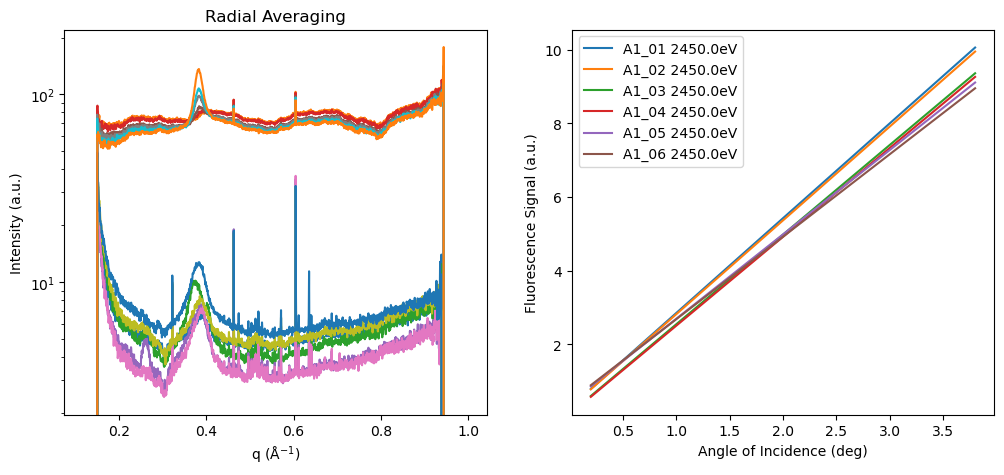

In [49]:
FLUOR_RANGE: tuple[float, float] = (0.8, 0.92)
"""Q-range for the fluorescence signal summation; define in a flat region away from any peaks/features!"""

# Plot the example data, and plot the fluorescence signal
fig: plt.Figure
ax: list[plt.Axes]
fig,ax = plt.subplots(1,2, figsize=(12,5))
for i, sample in enumerate(samples):
    sample_dir = os.path.join(RESULT_DIR, sample)
    line_profiles_dir = os.path.join(sample_dir, "line_profiles")
    for j, en in enumerate(sample_energies[i]):
        test_dataset = [datasets[i][j][test_file] for test_file in test_files]
        # Gather the fluor data
        fluor_data = np.zeros((len(test_dataset), 3)) # en, I, I_err
        for k, fnames in enumerate(test_dataset):
            ## Create the results directory for the sample
            fname = fnames[0]
            # Collect the metadata
            en_idx = fname.find('eV_')
            en2 = float(fname[en_idx-7:en_idx])
            ai_idx = fname.find("_ai")
            ai = float(fname[ai_idx+3:ai_idx+7])
            assert en == en2
            # Generate paths for the output files
            path_R = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_R.txt")

            # Load the data
            data = np.loadtxt(path_R, skiprows=3, delimiter="\t")
            q = data[:,0]
            I = data[:,1]
            I_err = data[:,2]
            
            # Find the fluorescence signal
            mask = (q > FLUOR_RANGE[0]) & (q < FLUOR_RANGE[1])
            fluor_data[k, 0] = ai
            fluor_data[k, 1] = np.trapz(I[mask], q[mask])
            fluor_data[k, 2] = np.trapz(I_err[mask], q[mask])
            
            # Plot the data
            ax[0].plot(q, I, label=f"{en} eV, {ai} deg")
            
        ax[1].plot(fluor_data[:,0], fluor_data[:,1], label=f"{sample} {en}eV")
        ax[1].fill_between(fluor_data[:,0], fluor_data[:,1] - fluor_data[:,2], fluor_data[:,1] + fluor_data[:,2], alpha=0.5)
    
# ax[0].axvspan(*FLUOR_RANGE, color="gray", alpha=0.5)
ax[0].set_xlabel("q (Å$^{-1}$)")
ax[0].set_ylabel("Intensity (a.u.)")
ax[0].set_title("Radial Averaging")
ax[0].set_yscale("log")
# ax[0].legend()
ax[1].set_xlabel("Angle of Incidence (deg)")
ax[1].set_ylabel("Fluorescence Signal (a.u.)")
ax[1].legend()
fig.show()

### Perform the reduction for all files, and generate videos if FFMPEG is installed.

##### Generate the video images function

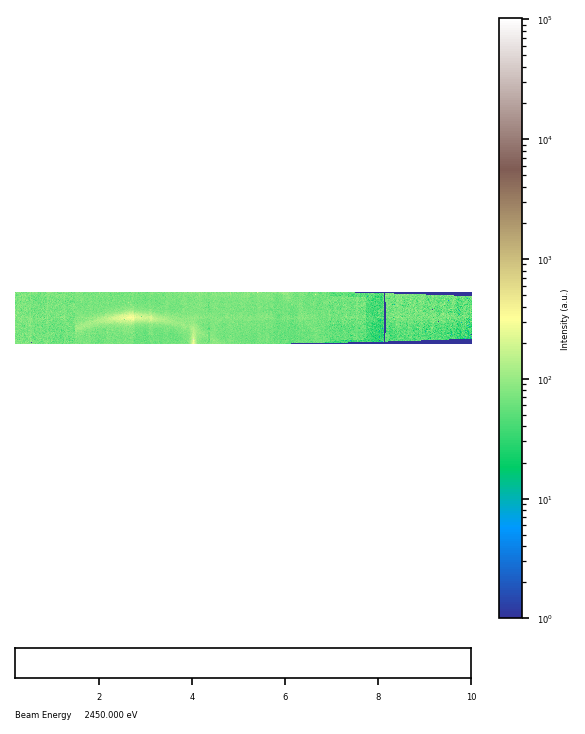

In [50]:
MIN_A: float = 0.2
MAX_A: float = 10

def generate_energy_video_figure(geom: SMI_beamline.SMI_geometry, 
                              dataset_minimum:float, 
                              dataset_maximum: float, 
                              en: float) -> plt.Figure:
    SMI_waxs = geom
    if len(SMI_waxs.imgs) == 3:
        # Works for single detector plots
        figsize = (4,5) 
    else:
        # Works for 0, 20  deg detector angles... generic?
        qp = SMI_waxs.qp
        qz = SMI_waxs.qz
        qp_diff = qp[0] - qp[1]
        qz_diff = qz[0] - qz[1]
        qmax = np.max([qp_diff, qz_diff])
        scale = 4
        figsize = (qp_diff/qmax * scale * 1.02, qz_diff/qmax * scale)
    
    fig = plt.figure(figsize = figsize, dpi=150)
    gs = fig.add_gridspec(2,2, width_ratios=[1,0.05], height_ratios=[1, 0.05])
    ax = fig.add_subplot(gs[0,0])
    ax_cmap = fig.add_subplot(gs[0,1])
    ax_ai = fig.add_subplot(gs[1,0])

    cmap = plt.get_cmap('terrain')
    norm = mplc.LogNorm(vmin=dataset_minimum, vmax=dataset_maximum, clip=True)
    mp = ax.matshow(SMI_waxs.img_st,
            extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]],
            cmap = cmap,
            norm=norm
    )
    colorbar = fig.colorbar(mp, cax=ax_cmap, orientation='vertical', location="right", fraction = 0.05)
    colorbar.ax.set_ylabel("Intensity (a.u.)", fontsize=4)
    colorbar.ax.tick_params(axis='both', which='major', labelsize=4)
    ax.axis('off')

    ax2 = ax_ai
    ax2.yaxis.set_ticks([])
    ax2.set_ylim(0,1)
    ax2.set_xscale("linear")
    ax2.set_xlim(MIN_A, MAX_A)
    ax2.tick_params(axis='both', which='major', labelsize=4)
    ax2.plot([en, en], [0, 1], 'r')
    ax2.set_xlabel(f"Beam Energy     {en:0.3f} eV", loc="left", fontsize=4)

    fig.tight_layout()
    return fig

if "dataset_minimum" in locals():
    plt.ion()
    matplotlib.interactive(True)
    
    SMI_waxs.open_data(RAW_DIR, fnames)
    apply_detector_mask(SMI_waxs)
    apply_flatfield(SMI_waxs, flatfield, flat_percentile=FLATFIELD_PERCENTILE, img_percentile=SAMPLE_PERCENTILE)
    energies_idx = flux_energies.index(en) # for normalisation
    for img in SMI_waxs.imgs:
        # img[:] = (img[:] / FLUX_NORM[energies_idx]).astype(np.int32)
        pass
    SMI_waxs.stitching_data(interp_factor=3, flag_scale=False, perpendicular=True)
    
    fig = generate_energy_video_figure(SMI_waxs, 1, dataset_maximum, en)


##### Reduce the lineprofiles and generate fluorescence profiles

In [44]:
OVERRIDE: bool = False
"""Whether to override the analysis reduction or not."""
STITCH_MINMAX: bool = False
"""Whether to stitch the data to find the minimum and maximum values for the dataset, 
otherwise just use raw values from 2D detector array using fabio."""

# Check the timing performance
timing:bool = False
tcheck = datetime.datetime.now()

# Run the script
plt.ioff()
matplotlib.interactive(False)
with tqdm.notebook.tqdm(total=len(samples), position=0, leave=True, desc="All Samples") as pbar:
    for i, sample in enumerate(samples):
        ## Create the results directory for the sample
        sample_dir = os.path.join(RESULT_DIR, sample)
        if not os.path.isdir(sample_dir):
            os.mkdir(sample_dir)
            
        ## Create the directories for the images and line profiles
        giwaxs_img_dir = os.path.join(sample_dir, "giwaxs_flatfielded_images")
        if not os.path.isdir(giwaxs_img_dir):
            os.mkdir(giwaxs_img_dir)
        line_profiles_dir = os.path.join(sample_dir, "line_profiles")
        if not os.path.isdir(line_profiles_dir):
            os.mkdir(line_profiles_dir)
            
        with tqdm.notebook.tqdm(total=len(sample_energies[i]), position=1, leave=False, desc="Energies") as pbar1:
            for j, en in enumerate(sample_energies[i]):
                
                # Check if dataset is already processed
                processed = True
                if OVERRIDE:
                    processed = False
                else:
                    for k, fnames in enumerate(datasets[i][j]):
                        fname = fnames[0]
                        # Collect the metadata
                        en_idx = fname.find('eV_')
                        en2 = float(fname[en_idx-7:en_idx])
                        ai_idx = fname.find("_ai")
                        ai = float(fname[ai_idx+3:ai_idx+7])
                        assert en == en2
                        
                        # Generate paths for the output files
                        path_det_img = os.path.join(giwaxs_img_dir, f"{sample}_giwaxs_{en:0.2f}eV_{ai:0.3f}deg.png")
                        path_OOP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_OOP.txt")
                        path_IP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_IP.txt")
                        path_R = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_R.txt")
                        path_det_line_profiles_img = os.path.join(sample_dir, f"{sample}_{en}_line_profile_angles.png")
                        
                        if not all([os.path.isfile(path) for path in [path_det_img, path_OOP, path_IP, path_R, path_det_line_profiles_img]]):
                            processed = False
                            break
                        
                if processed:
                    print(f"Skipping processed dataset for sample {sample} at {en} energy.")
                    pbar1.total -= 1
                    pbar1.update(0)
                    continue
                
                dataset_maximum = None
                dataset_minimum = None
                with tqdm.notebook.tqdm(total=len(datasets[i][j]), position=2, leave=False, desc="Finding dataset maximum / minimum") as pbar2:
                    for k, fnames in enumerate(datasets[i][j]):
                        fname = fnames[0]
                        # Collect the metadata
                        en_idx = fname.find('eV_')
                        en2 = float(fname[en_idx-7:en_idx])
                        ai_idx = fname.find("_ai")
                        ai = float(fname[ai_idx+3:ai_idx+7])
                        assert en2==en
                        
                        if STITCH_MINMAX:
                        
                            # Update the geometry
                            if timing:
                                tcheck = datetime.datetime.now()
                                SMI_waxs.alphai = ai
                                tupdate = datetime.datetime.now()
                                print(f"Time to update geometry: {tupdate - tcheck}")
                                        
                                
                                tcheck = datetime.datetime.now()
                                SMI_waxs.wav = en2wav(en)
                                tupdate = datetime.datetime.now()
                                print(f"Time to update wavelength: {tupdate - tcheck}")
                                
                                # Flatfield / masked normalized data
                                tcheck = datetime.datetime.now()
                                SMI_waxs.open_data(RAW_DIR, fnames)
                                tupdate = datetime.datetime.now()
                                print(f"Time to open data: {tupdate - tcheck}")
                                
                                tcheck = datetime.datetime.now()
                                apply_detector_mask(SMI_waxs)
                                apply_flatfield(SMI_waxs, flatfield, flat_percentile=FLATFIELD_PERCENTILE, img_percentile=SAMPLE_PERCENTILE)
                                tupdate = datetime.datetime.now()
                                print(f"Time to apply flatfield and mask: {tupdate - tcheck}")
                                
                                energies_idx = global_energies.tolist().index(en) # for normalisation
                                for img in SMI_waxs.imgs:
                                    # img[:] = (img[:] / FLUX_NORM[energies_idx]).astype(np.int32)
                                    pass
                                    
                                tcheck = datetime.datetime.now()
                                SMI_waxs.stitching_data(interp_factor=3, flag_scale=False, timing=True, perpendicular=True)
                                tupdate = datetime.datetime.now()
                                print(f"Time to stitch data: {tupdate - tcheck}")
                            
                            else:
                                # Unnecessary to set the correct geometry and wavelength for each image when finding min/max
                                # SMI_waxs.alphai = ai
                                # SMI_waxs.wav = en2wav(en)
                                SMI_waxs.open_data(RAW_DIR, fnames)
                                apply_detector_mask(SMI_waxs)
                                apply_flatfield(SMI_waxs, flatfield, flat_percentile=FLATFIELD_PERCENTILE, img_percentile=SAMPLE_PERCENTILE)
                                
                                energies_idx = global_energies.tolist().index(en) # for normalisation
                                for img in SMI_waxs.imgs:
                                    # img[:] = (img[:] / FLUX_NORM[energies_idx]).astype(np.int32)
                                    pass
                                SMI_waxs.stitching_data(interp_factor=3, flag_scale=False, perpendicular=True)
                                
                            # Collect the maximum and minimum values
                            if dataset_maximum is None:
                                dataset_maximum = np.max(SMI_waxs.img_st)
                            else:
                                dataset_maximum = np.max([dataset_maximum, np.max(SMI_waxs.img_st)])
                                
                            if dataset_minimum is None:
                                dataset_minimum = np.min(SMI_waxs.img_st[SMI_waxs.img_st > 0])
                            else:
                                min_val = np.min(SMI_waxs.img_st[SMI_waxs.img_st > 0])
                                dataset_minimum = np.min([dataset_minimum, min_val])
                        else:
                            # Open the file using pyFAI
                            for file in fnames:
                                raw_img = fabio.open(os.path.join(RAW_DIR, file)).data
                                if dataset_maximum is None:
                                    dataset_maximum = np.max(raw_img)
                                else:
                                    dataset_maximum = np.max([dataset_maximum, np.max(raw_img)])
                                if dataset_minimum is None:
                                    dataset_minimum = np.min(raw_img[raw_img > 0])
                                else:
                                    min_val = np.min(raw_img[raw_img > 0])
                                    dataset_minimum = np.min([dataset_minimum, min_val])
                        pbar2.update(1)
                
                cmap = plt.get_cmap('viridis')
                norm = mplc.LogNorm(vmin=dataset_minimum, vmax=dataset_maximum)
                
                
                # Gather the fluor data
                fluor_data = np.zeros((len(datasets[i][j]), 3))
                
                # Create paths for fluor figure and data
                path_flour_fig = os.path.join(sample_dir, f"{sample}_{ai}_fluorescence.png")
                path_flour_data = os.path.join(sample_dir, f"{sample}_{ai}_fluorescence_data.txt")
                
                with tqdm.notebook.tqdm(total=len(datasets[i][j]), position=1, leave=False, desc="Sample dataset") as pbar2:
                    # For each file in the sample
                    for k, fnames in enumerate(datasets[i][j]):
                        fname = fnames[0]
                        # Collect the metadata
                        en_idx = fname.find('eV_')
                        en2 = float(fname[en_idx-7:en_idx])
                        ai_idx = fname.find("_ai")
                        ai = float(fname[ai_idx+3:ai_idx+7])
                        assert en2 == en
                        
                        # Generate paths for the output files
                        path_det_img = os.path.join(giwaxs_img_dir, f"{sample}_giwaxs_{en:0.2f}eV_{ai:0.3f}deg.png")
                        path_OOP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_OOP.txt")
                        path_IP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_IP.txt")
                        path_R = os.path.join(line_profiles_dir, f"{sample}_line_profile_{en:0.2f}eV_{ai:0.3f}deg_R.txt")
                        path_det_line_profiles_img = os.path.join(sample_dir, f"{sample}_{en}_line_profile_angles.png")
                        
                        # Do not override the files if they "all" exist already. Override partial file sets though.
                        if (not OVERRIDE 
                            and os.path.isfile(path_det_img) 
                            and os.path.isfile(path_OOP) 
                            and os.path.isfile(path_IP) 
                            and os.path.isfile(path_R)
                            and os.path.isfile(path_flour_fig)
                            and os.path.isfile(path_flour_data)
                            and (k != 0 or os.path.isfile(path_det_line_profiles_img))):
                            pbar2.total -= 1 # Reduce the total count
                            continue
                        
                        # Update the geometry
                        SMI_waxs.alphai = ai
                        SMI_waxs.wav = en2wav(en)
                        
                        # flatfield / masked normalized data
                        SMI_waxs.open_data(RAW_DIR, fnames)
                        apply_detector_mask(SMI_waxs)
                        apply_flatfield(SMI_waxs, flatfield, flat_percentile=FLATFIELD_PERCENTILE, img_percentile=SAMPLE_PERCENTILE)
                        energies_idx = flux_energies.index(en) # for normalisation
                        for img in SMI_waxs.imgs:
                            # img[:] = (img[:] / FLUX_NORM[energies_idx]).astype(np.int32)
                            pass
                        SMI_waxs.stitching_data(interp_factor=2, flag_scale=True, timing= True, perpendicular=True)
                        
                        # Setup a figure and open the file
                        fig = generate_energy_video_figure(SMI_waxs, 1, dataset_maximum, en)
                        fig.savefig(path_det_img)
                        ax = fig.get_axes()[0]
                        
                        if k==0:
                            # Plot the azimuthal and radial angles
                            colors = ['r', 'orange', 'white'][::-1]
                            for angle, width in zip([AZIMUTHAL_INPLANE, AZIMUTHAL_OUTOFPLANE, AZIMUTHAL_RADIAL], [AZIMUTHAL_WIDTH, AZIMUTHAL_WIDTH, RADIAL_WIDTH]):
                                # Generate a set of x points to plot lines of.
                                q_x = np.linspace(0, SMI_waxs.qp[-1], 100)
                                # Calculate the x and y gradients for the lines
                                m1 = np.tan(np.deg2rad(angle - width)) if angle - width != 90 else np.inf
                                m2 = np.tan(np.deg2rad(angle + width)) if angle + width != 90 else np.inf
                                # Calculate the x & y values for the lines
                                q_x1 = q_x if m1 != np.inf else np.zeros(100)
                                q_x2 = q_x if m2 != np.inf else np.zeros(100)
                                y1 = m1 * q_x if m1 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                                y2 = m2 * q_x if m2 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                                # Plot the lines
                                color = colors.pop()
                                ax.plot(q_x1, y1, color=color, linestyle='-', label=f"{angle} deg")
                                ax.plot(q_x2, y2, color=color, linestyle='-')
                                # If gradient is inf, calculate an alternative fill between
                                if m2 == np.inf:
                                        ax.fill_betweenx(y1, q_x1, q_x2, color=color, alpha=0.1)
                                else:
                                        ax.fill_between(q_x, y1, y2, color=color, alpha=0.1)
                            ax.set_xlim(*SMI_waxs.qp)
                            ax.set_ylim(*SMI_waxs.qz)
                            ax.legend()
                            fig.savefig(path_det_line_profiles_img, dpi=300)
                        plt.close(fig) # Save memory
                        
                        # Perform the radial/azimuthal averaging
                        # In plane and out of plane
                        SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                azimuth_range=[90 - (AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH) , 90 - (AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                                                npt = NPOINTS_RADIAL_AVE)
                        q0_IP, I0_IP, I0_IP_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                        SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                azimuth_range=[90 - (AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH), 90 - (AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                                                npt = NPOINTS_RADIAL_AVE)
                        q0_OOP, I0_OOP, I0_OOP_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                        # Repeat IP and OOP for the consistency checking
                        SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                azimuth_range=[-90+(AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH), -90+(AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                                                npt = NPOINTS_RADIAL_AVE)
                        q0_IP2, I0_IP2, I0_IP2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                        SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                azimuth_range=[-90+(AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH) , -90+(AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                                                npt = NPOINTS_RADIAL_AVE)
                        q0_OOP2, I0_OOP2, I0_OOP2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                        # Radial averaging
                        SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                azimuth_range=[90-(AZIMUTHAL_RADIAL - RADIAL_WIDTH), 90-(AZIMUTHAL_RADIAL + RADIAL_WIDTH)], 
                                                npt = NPOINTS_RADIAL_AVE)
                        q0_R, I0_R, I0_R_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                        # Repeat radial averaging for consistency checking
                        SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                azimuth_range=[-90+(AZIMUTHAL_RADIAL - RADIAL_WIDTH), -90+(AZIMUTHAL_RADIAL + RADIAL_WIDTH)], 
                                                npt = NPOINTS_RADIAL_AVE)
                        q0_R2, I0_R2, I0_R2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err
                        
                        # Save the line profiles 
                        header = ("Main Data\t\tMirror-Y axis Data\t\n" 
                                + "q (Å^-1)\tI (a.u.)\tI_err (a.u.)\tq (Å^-1)\tI (a.u.)\tI_err (a.u.)\n")
                        delim = "\t"
                        kwargs = {"header": header, "delimiter": delim}
                        np.savetxt(path_OOP, np.array([q0_OOP, I0_OOP, I0_OOP_err, q0_OOP2, I0_OOP2, I0_OOP2_err]).T, **kwargs)
                        np.savetxt(path_IP, np.array([q0_IP, I0_IP, I0_IP_err, q0_IP2, I0_IP2, I0_IP2_err]).T, **kwargs)
                        np.savetxt(path_R, np.array([q0_R, I0_R, I0_R_err, q0_R2, I0_R2, I0_R2_err]).T, **kwargs)
                        
                        # Calculate the Fluorescence data
                        mask = (q0_R > FLUOR_RANGE[0]) & (q0_R < FLUOR_RANGE[1])
                        fluor_data[k, 0] = en
                        fluor_data[k, 1] = np.trapz(I0_R[mask], q0_R[mask])
                        fluor_data[k, 2] = np.trapz(I0_R_err[mask], q0_R[mask])
                        
                        
                        pbar2.update(1)
                        plt.close("all")
                        # break # Only do the first file for now.
                
                # Save and plot the Fluroescence data
                idx = np.argsort(fluor_data[:,0]) #sort by energy
                fluor_data = fluor_data[idx]
                if not os.path.isfile(path_flour_data) or OVERRIDE:
                    with open(path_flour_data, "w") as f:
                        f.write("Energy (eV)\tFluorescence (a.u.)\tFluorescence Error (a.u.)\n")
                        np.savetxt(f, fluor_data, delimiter="\t")
                
                if not os.path.isfile(path_flour_fig) or OVERRIDE:
                    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
                    ax.plot(fluor_data[:,0], fluor_data[:,1], label="Fluorescence")
                    ax.fill_between(fluor_data[:,0], fluor_data[:,1] - fluor_data[:,2], fluor_data[:,1] + fluor_data[:,2], alpha=0.5)
                    ax.set_xlabel("Energy (eV)")
                    ax.set_ylabel("Fluorescence (a.u.)")
                    ax.set_title(f"{sample} Fluorescence")
                    fig.tight_layout()
                    fig.savefig(path_flour_fig)
                    plt.close(fig)
                pbar1.update(1)
        pbar.update(1)
        
# Turn back on interactive plotting
plt.ion()
matplotlib.interactive(True)

All Samples:   0%|          | 0/6 [00:00<?, ?it/s]

Energies:   0%|          | 0/1 [00:00<?, ?it/s]

Skipping processed dataset for sample A1_01 at 2450.0 energy.


Energies:   0%|          | 0/1 [00:00<?, ?it/s]

Skipping processed dataset for sample A1_02 at 2450.0 energy.


Energies:   0%|          | 0/1 [00:00<?, ?it/s]

Skipping processed dataset for sample A1_03 at 2450.0 energy.


Energies:   0%|          | 0/1 [00:00<?, ?it/s]

Skipping processed dataset for sample A1_04 at 2450.0 energy.


Energies:   0%|          | 0/1 [00:00<?, ?it/s]

Skipping processed dataset for sample A1_05 at 2450.0 energy.


Energies:   0%|          | 0/1 [00:00<?, ?it/s]

Finding dataset maximum / minimum:   0%|          | 0/82 [00:00<?, ?it/s]

Sample dataset:   0%|          | 0/82 [00:00<?, ?it/s]

WAZ HERE
-0.2 PUSH TO TRANFORM
-0.2 PUSH TO TRANFORM
-0.2 PUSH TO TRANFORM
Time to calc perpendicular geometry: 0:00:00.000088
Time to stitch the images: 0:00:06.100053
WAZ HERE
-0.22 PUSH TO TRANFORM
-0.22 PUSH TO TRANFORM
-0.22 PUSH TO TRANFORM
Time to calc perpendicular geometry: 0:00:00.000091
Time to stitch the images: 0:00:05.481954
WAZ HERE
-0.24 PUSH TO TRANFORM
-0.24 PUSH TO TRANFORM
-0.24 PUSH TO TRANFORM
Time to calc perpendicular geometry: 0:00:00.000094
Time to stitch the images: 0:00:06.108968
WAZ HERE
-0.26 PUSH TO TRANFORM
-0.26 PUSH TO TRANFORM
-0.26 PUSH TO TRANFORM
Time to calc perpendicular geometry: 0:00:00.000082
Time to stitch the images: 0:00:06.084923
WAZ HERE
-0.28 PUSH TO TRANFORM
-0.28 PUSH TO TRANFORM
-0.28 PUSH TO TRANFORM
Time to calc perpendicular geometry: 0:00:00.000111
Time to stitch the images: 0:00:06.177881
WAZ HERE
-0.3 PUSH TO TRANFORM
-0.3 PUSH TO TRANFORM
-0.3 PUSH TO TRANFORM
Time to calc perpendicular geometry: 0:00:00.000113
Time to stitch t

In [24]:
# Turn back on interactive plotting
plt.ion()
matplotlib.interactive(True)